In [ ]:
import re
from pathlib import Path

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Flight Header DataFrame

- The dataset is grouped into two - 1) `all_flights/` and 2) `2days/`
- The `all_flights` dataset includes all NGAFID flight data, representing the dataset before partitioning into the `2days` dataset
- The `2days` dataset looks only at flights 2 days before and after a maintenance issue 
- Lets start by loading and looking at out first dataset, found in the `all_fligths/flight_header.csv`

In [16]:
# Path to all_flights flight_header.csv
project_dir = Path.cwd().parent
flight_header_path = (
    project_dir / "data" / "all_flights" / "all_flights" / "flight_header.csv"
)
assert flight_header_path.exists()

flight_header_df = pd.read_csv(flight_header_path, index_col="Master Index")
flight_header_df.head()

,before_after,date_diff,flight_length,label,hierarchy,number_flights_before
Master Index,,,,,,
1,before,-1,4723.0,intake gasket leak/damage,NaN,0
2,before,-2,4649.0,intake gasket leak/damage,NaN,3
3,same,0,40.0,intake gasket leak/damage,NaN,-1
4,before,0,14.0,intake gasket leak/damage,NaN,0
5,same,0,683.0,intake gasket leak/damage,NaN,-1


In [17]:
flight_header_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28935 entries, 1 to 32820
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   before_after           28935 non-null  object 
 1   date_diff              28935 non-null  int64  
 2   flight_length          28935 non-null  float64
 3   label                  28935 non-null  object 
 4   hierarchy              10581 non-null  object 
 5   number_flights_before  28935 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 1.5+ MB


In [18]:
flight_header_df.isna().any()

before_after             False
date_diff                False
flight_length            False
label                    False
hierarchy                 True
number_flights_before    False
dtype: bool

In [19]:
flight_header_df.shape

(28935, 6)

We have 28935 rows of data, with 6 columns  - each row is a flight id, or flight record with length of flight and maintence information/classification

All of our columns are fully populated except the hierarchy column, which has 18,354 null records. Since this column represents the maintance issue hierarchy, we can leave as is for now since we don't plan on doing anything with that column just yet.

We are expecting int64 or float64 type for our "date_diff", "flight_length", and "number_flights_before" columns

The `before_after`, representing whether maintenance occurred before or after the flight, includes the value `same`, meaning maintenance occurred the same day/during maintenance

| Column | Description | Datatype|
| - | - | - |
| Master Index | Flight record primary key, represents a single flight | int |
| before_after | Whether a flight occurred before or after a maintenance action | str |
| date_diff | Days before or after maintenance | int |
| flight_length | Duration of flight in seconds | float |
| label | Maintenance issue, 36 unique issues | str |
| Hierarchy | Maintenance issue category, NaN is other, 5 unique groups | str |
| number_flights_before | The nth flight before maintenance, -1 is N/A, 0 is immediately before | int |


In [20]:
# Number of maintenance hierarchies/categories
flight_header_df["hierarchy"].unique()

array([nan, 'engine', 'baffle', 'oil', 'cylinder'], dtype=object)

In [21]:
# Number of unique maintenance labels
len(flight_header_df["label"].unique())

36

- `label` column is maintence issue type, 36 total classes of maintenance 
- 5 `hierarchy`s of maintenance
    1. Baffle
    2. Cylinder
    3. Engine
    4. Oil
    5. NaN (other)

In [22]:
flight_header_df.describe()

,date_diff,flight_length,number_flights_before
count,28935.000000,28935.000000,28935.000000
mean,-0.025920,3879.015725,0.121445
std,3.721469,3065.589572,1.634050
min,-108.000000,12.000000,-1.000000
25%,-1.000000,419.000000,-1.000000
50%,0.000000,4402.000000,-1.000000
75%,1.000000,5771.000000,1.000000
max,70.000000,30059.000000,4.000000


Nothing looks out of place for our statistical analysis of the data

Lets look at the `label` column distribution 

In [23]:
# Top 5 maintenance issues
flight_header_df["label"].value_counts().head()

label
intake gasket leak/damage                     10140
rocker cover leak/loose/damage                 5219
intake tube/bolt/seal/boot loose or damage     1372
baffle crack/damage/loose/miss                 1294
baffle plug need repair/replace                1142
Name: count, dtype: int64

Many of these labels for maintenance issues have similar aircraft part associated with them, so we can categorize them into `part_name` categories to make our analysis easier. We will create a dictionary of rules of regex patterns to find in each label, and categorize it based on the associated part name.

In [24]:
# Add a PartName column to flight_header_df
Rules = [
    ("baffle kit", r"\bbaffle\s*(seal|crack|spring|mount|tie|bracket)\b"),
    ("baffle screw", r"\bbaffle\s*screw\b"),
    ("baffle plug", r"\bbaffle\s*plug\b"),
    ("baffle rivet ", r"\bbaffle\s*rivet \b"),
    ("intake gasket", r"\bintake\s*gasket\b"),
    ("intake tube/bolt/seal/boot", r"\bintake\s*(tube|bolt|seal|boot)\b"),
    ("engine", r"\bengine\b"),
    ("rocker cover", r"\brocker\s*cover\b"),
    ("oil cooler", r"\boil\s*cooler\b"),
    ("oil pressure", r"\boil\s*(leak|pressure)\b"),
    ("oil dipstick", r"\boil\s*(dipstick|return)\b"),
    ("cowling", r"\bcowling\b"),
    ("cylinder", r"\bcylinder\b"),
    ("drain line/tube", r"\bdrain\s*(line|tube)\b"),
    ("mixture", r"\bmixture\b"),
    ("spark plug", r"\bspark\s*plug\b"),
    ("magneto", r"\bmagneto\b"),
    ("induction", r"\binduction\b"),
    ("other", r".*"),
]


def categorize_part(label: str) -> str:
    """Returns part name category given maintenance label"""
    for part_name, pattern in Rules:
        if re.search(pattern, label, re.IGNORECASE):
            return part_name
    return "other"

In [25]:
flight_header_df["part_name"] = flight_header_df["label"].apply(categorize_part)
flight_header_df["part_name"].value_counts()

part_name
intake gasket                 10140
rocker cover                   5219
baffle kit                     3191
engine                         2959
cylinder                       1578
intake tube/bolt/seal/boot     1372
baffle plug                    1142
baffle screw                    894
other                           831
oil cooler                      312
drain line/tube                 228
baffle rivet                    224
cowling                         211
oil dipstick                    151
magneto                         141
induction                       133
oil pressure                    130
mixture                          40
spark plug                       39
Name: count, dtype: int64

This is much better to look at and analyze, here we can see that intake gaskets are the aircraft part that needs the most maintenance. 

## Maintence Label Prices

Before we look at the second dataset connected to the flight_header_df, we want to include the price it takes to replace each of the partNames above. Unfortunately, this dataset doesn't provide prices, and it was difficult to find any other existing dataset out there that does. This can be because prices are always changing, and can vary from one producer/aircraft type to another.

For our analysis, we have found an online aircraft parts supplier, https://www.chiefaircraft.com/aircraft.html and grabbed the prices they have on their website as of November 11th, 2025. 

Note: The price of "other" was calculated by taking the average of all the other prices

In [26]:
prices_csv_path = project_dir / "data" / "prices.csv"

# prices_dict = {
#     "part_name": ["baffle kit", "baffle screw", "baffle plug", "baffle rivet ", "intake gasket",
#                  "intake tube/bolt/seal/boot", "engine", "rocker cover", "oil cooler", "oil pressure",
#                  "oil dipstick", "cowling", "cylinder", "drain line/tube", "mixture",
#                  "spark plug", "magneto", "induction", "other"],
#     "price_usd": [419.95, 6.95, 39.95, 24.50, 4.50,
#                  16.50, 839.99, 11.25, 1189.00, 265.00,
#                  8.50, 1190.00, 795.00, 19.95, 215.95,
#                  44.00, 859.00, 169.00, 305.95]

# }

# prices_df = pd.DataFrame(prices_dict)
# prices_df.to_csv(prices_csv_path, index=False)

prices_df = pd.read_csv(prices_csv_path)
prices_df.head()

,part_name,price_usd
0,baffle kit,419.95
1,baffle screw,6.95
2,baffle plug,39.95
3,baffle rivet,24.50
4,intake gasket,4.50


Need to add `price_usd`, but cannot merge without losing the flight record index, so use the below function to lookup prices

In [27]:
def get_part_price(part_name: str) -> float:
    """Returns price_usd given part_name"""
    mask = prices_df["part_name"] == part_name
    if not mask.any():
        mask = prices_df["part_name"] == "other"
    return prices_df.loc[mask, "price_usd"].item()

In [28]:
flight_header_df["prices_usd"] = flight_header_df["part_name"].apply(get_part_price)

In [29]:
flight_header_df.head()

,before_after,date_diff,flight_length,label,hierarchy,number_flights_before,part_name,prices_usd
Master Index,,,,,,,,
1,before,-1,4723.0,intake gasket leak/damage,NaN,0,intake gasket,4.5
2,before,-2,4649.0,intake gasket leak/damage,NaN,3,intake gasket,4.5
3,same,0,40.0,intake gasket leak/damage,NaN,-1,intake gasket,4.5
4,before,0,14.0,intake gasket leak/damage,NaN,0,intake gasket,4.5
5,same,0,683.0,intake gasket leak/damage,NaN,-1,intake gasket,4.5


In [30]:
flight_header_df.describe()

,date_diff,flight_length,number_flights_before,prices_usd
count,28935.000000,28935.000000,28935.000000,28935.000000
mean,-0.025920,3879.015725,0.121445,218.936975
std,3.721469,3065.589572,1.634050,332.606137
min,-108.000000,12.000000,-1.000000,4.500000
25%,-1.000000,419.000000,-1.000000,4.500000
50%,0.000000,4402.000000,-1.000000,11.250000
75%,1.000000,5771.000000,1.000000,419.950000
max,70.000000,30059.000000,4.000000,1190.000000


In [31]:
flight_header_df.loc[flight_header_df["part_name"] == "other", "label"].value_counts()

label
pilot/in-flight noticed issue    579
aircraft start/external issue    252
Name: count, dtype: int64

The part name labeled "other" is mainly for the labels "aircraft start/external issue" and "pilot/in-flight noticed issue" which don't specify a part as the issue

## (All) Flights Dataset

In [32]:
# Flight Data df
flight_data_path = project_dir / "data" / "all_flights" / "all_flights" / "one_parq"
assert flight_data_path.exists()

flight_data_df = dd.read_parquet(flight_data_path)
flight_data_df = flight_data_df.rename_axis("flight_id")
# flight_data_df = flight_data_df.reset_index()
flight_data_df.head()

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,E1 EGT2,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,timestep,cluster
flight_id,,,,,,,,,,,,,,,,,,,,,
1,28.8,NaN,0.8,NaN,48.89,44.06,13.28,168.55,82.51,2519.7,...,1317.44,1298.97,1322.83,12.8,144.89,29.61,0.01,3010.7,3151,c_28
1,28.8,NaN,0.8,NaN,48.93,44.06,13.31,168.60,82.51,2519.4,...,1316.64,1300.68,1322.15,12.8,144.53,49.78,-0.00,3011.3,3150,c_28
1,28.8,NaN,0.9,NaN,48.96,44.06,13.36,168.65,82.51,2520.3,...,1317.20,1301.05,1323.12,12.8,144.15,58.68,-0.01,3011.8,3149,c_28
1,28.8,NaN,0.7,NaN,48.86,44.06,13.30,168.64,82.51,2519.3,...,1317.73,1302.14,1321.93,12.8,143.79,47.31,-0.00,3012.2,3148,c_28
1,28.8,NaN,0.6,NaN,48.87,44.06,13.30,168.65,82.51,2518.8,...,1318.00,1308.52,1316.99,12.8,143.45,36.05,-0.01,3012.3,3147,c_28


In [33]:
# ### Creates parquet files organized by flight_id ###
# flights_path = project_dir / "data" / "flights"
# flight_data_df.reset_index().to_parquet(
#     flights_path, partition_on=["flight_id"], engine="pyarrow", compression="snappy"
# )

| Column | Description | Datatype |
| - | - | - |
| volt1 | Main electrical system bus voltage | float |
| volt2 | Essential bus (standby battery) bus voltage | float |
| amp1 | Ammeter on the main battery (+charging, -dicharging) | float |
| amp2 | Ammeter on the standby battery (+charging, -discharging) | float |
| FQtyL | Fuel quantity left | float |
| FQtyR | Fuel quantity right | float |
| E1 FFlow | Engine fuel flow rate | float |
| E1 OilT | Engine oil temperature | float |
| E1 OilP | Engine oil pressure | float |
| E1 RPM | Engine rotations per minute | float |
| E1 CHT1 | 1st cylinder head temperature | float |
| E1 CHT2 | 2nd cylinder head temperature | float |
| E1 CHT3 | 3rd cylinder head temperature | float |
| E1 CHT4 | 4th cylinder head temperature | float |
| E1 EGT1 | 1st exhaust gas temperature | float |
| E1 EGT2 | 2nd exhaust gas temperature | float |
| E1 EGT3 | 3rd exhaust gas temperature| float |
| E1 EGT4 | 4th exhaust gas temperature| float |
| OAT | Outside air temperature | float |
| IAS | Indicated air speed | float |
| VSPd | Vertical speed  | float |
| NormAc | Normal acceleration | float |
| AltMSL | Altitude miles above sea level | float |
| timestep | flight time series step | int |
| cluster | label class | str |

Voltages: volt1, volt2

Amperages: amp1, amp2

Fuel metrics: FQtyL, FQtyR, FFflow

Engine metrics: RPM, OilP, OilT

Temperatures: CHT1–CHT4, EGT1–EGT4

Flight metrics: IAS, VSpd, NormAc

Altitude: AltMSL

Outside Air Temp: OAT

In [34]:
# Number of rows
flight_data_df.shape[0].compute()

112239320

- The dask dataframe is evaluated lazily due to the large number of rows (112,239,320)

In [35]:
# Number of unique flights
flight_data_index = flight_data_df.index.compute()
nflights = flight_data_index.nunique()
nflights

28935

- There are 28,935 flight records

The sensor dataset includes NaN values at certain timesteps - this is may be explained by initialization of the sensor at the beginning of the flight, failure of the sensor, and a failure of the recording system

In [36]:
# Check which columns have NaN values
flight_data_df.isna().any().compute()

volt1        True
volt2        True
amp1         True
amp2         True
FQtyL        True
FQtyR        True
E1 FFlow     True
E1 OilT      True
E1 OilP      True
E1 RPM       True
E1 CHT1      True
E1 CHT2      True
E1 CHT3      True
E1 CHT4      True
E1 EGT1      True
E1 EGT2      True
E1 EGT3      True
E1 EGT4      True
OAT          True
IAS          True
VSpd         True
NormAc       True
AltMSL       True
timestep    False
cluster     False
dtype: bool

- To reduce the dataset size, drop rows with NaN, same day flights, any flights < 30 mins in length, and only flights with +-5 days of maintenance, choosing a timeframe which provides the most data while being able to evaulate as a pandas DataFrame
- Dropping same day flight because it is unclear whether the flight occurs before or after maintenance action
- Dropping short flights because many of those flight's sensor readings include NaN
- Dropping date_diff larger than 5 because most of the data is within 1 day

In [37]:
# Flights > 30 mins
flight_length_mask = flight_header_df["flight_length"] > 30 * 60

# Same day flights
same_day_mask = flight_header_df["before_after"] != "same"

# N <= date_diff <= N
ndays = 4  # +1 to calculate actual number of days
date_diff_mask = (flight_header_df["date_diff"] >= -ndays) & (
    flight_header_df["date_diff"] <= ndays
)

In [56]:
def get_flight_df(flight_id: int) -> pd.DataFrame:
    """Returns pandas DataFrame given parquet flight_id"""
    # To df
    flights_dir = project_dir / "data" / "flights"
    flights_df = dd.read_parquet(flights_dir / f"flight_id={flight_id}")
    npartitions = flights_df.index.nunique().compute()
    flight_df = flights_df.set_index("flight_id", npartitions=npartitions)
    df: pd.DataFrame = flight_df.loc[flight_id].compute()

    # Sort by timestep
    # df = df.reset_index(drop=True)
    return df.sort_values(by="timestep")

In [57]:
get_flight_df(1).head()

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,E1 EGT2,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,timestep,cluster
flight_id,,,,,,,,,,,,,,,,,,,,,
1,28.9,NaN,9.6,NaN,54.0,54.0,3.67,62.99,77.07,1104.9,...,764.40,1030.30,942.73,11.8,0.0,6.85,-0.01,843.6,0,c_28
1,28.9,NaN,9.6,NaN,54.0,54.0,3.52,63.00,77.17,1106.4,...,753.64,1033.56,943.74,11.8,0.0,-25.49,0.00,843.4,1,c_28
1,28.9,NaN,9.6,NaN,54.0,54.0,3.17,63.06,77.05,1118.8,...,774.23,1036.48,945.98,11.8,0.0,7.85,0.01,843.2,2,c_28
1,28.9,NaN,9.6,NaN,54.0,54.0,3.06,63.06,77.06,1118.3,...,820.81,1038.11,948.33,11.8,0.0,-14.46,-0.00,842.4,3,c_28
1,28.9,NaN,9.6,NaN,54.0,54.0,3.03,63.11,76.95,1111.7,...,860.03,1038.58,948.08,11.8,0.0,-21.00,0.00,841.5,4,c_28


In [40]:
# WIP TODO
# # Map cluster to label
# num_clusters = 36
# label_cluster_map = {"label": [], "cluster": []}
# for flight_id in flight_data_index:
#     if len(label_cluster_map.keys()) == num_clusters:
#         break

#     flight_df = get_flight_df(flight_id)
#     clusters = flight_df["cluster"].unique()
#     assert len(clusters) == 1
#     cluster = list(clusters)[0]
#     if cluster in label_cluster_map.values():
#         continue

#     label = flight_header_df.loc[flight_id, "label"]
#     label_cluster_map["label"].append(label)
#     label_cluster_map["cluster"].append(cluster)

# # Save to df
# cluster_df = pd.DataFrame(label_cluster_map)
# cluster_csv_path = project_dir / "data" / "cluster.csv"
# cluster_df.to_csv(cluster_csv_path)

Ok, lets start with one aircraft part and see if we can use a model to decipher when is optimal time to schedule maintenance to improve cost by repairing instead of replacing.

We can look at engine, this is a good part to look at for the following reasons
- appears in 2959 maintenance issues according to our first df
- Has a high replacement cost: 839.99 USD
- has sensor relationships from the second df: FFflow, RPM, OilP, OilT

In [60]:
def get_hierarchy_df(hierarchy: str) -> pd.DataFrame:
    """Creates df by hierarchy"""
    hierarchy_csv_path = project_dir / "data" / f"{hierarchy}.csv"
    if hierarchy_csv_path.exists():
        return pd.read_csv(hierarchy_csv_path)

    # Create a mask
    hierarchy_mask = flight_header_df["hierarchy"] == hierarchy
    flight_header_df.loc[hierarchy_mask, "label"].value_counts()

    # Create mask
    header_masked = flight_header_df[
        hierarchy_mask & flight_length_mask & same_day_mask & date_diff_mask
    ]
    flight_ids = header_masked.index
    # print(len(flight_ids))

    # append dfs to list
    dfs = []
    for flight_id in flight_ids:
        flight_df = get_flight_df(flight_id)
        # hierarchy_df = pd.concat((hierarchy_df, flight_df))
        dfs.append(flight_df)

    # to single df
    hierarchy_df = pd.concat(dfs, axis=0)  
    hierarchy_df.to_csv(hierarchy_csv_path, index_label="flight_id")

    return hierarchy_df


In [61]:
# engine df
hierarchy_df = get_hierarchy_df("engine")
hierarchy_df.head()

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,E1 EGT2,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,timestep,cluster
flight_id,,,,,,,,,,,,,,,,,,,,,
6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,1019.0,...,938.69,919.91,939.09,-6.2,0.0,-0.14,0.00,842.2,0,c_23
6866,27.9,27.9,4.1,0.3,23.22,24.0,2.33,64.72,62.93,1019.0,...,938.69,919.91,939.09,-6.2,0.0,-0.14,0.00,842.2,1,c_23
6866,28.0,27.9,4.0,0.3,23.24,24.0,2.32,64.77,63.44,1042.1,...,944.93,925.34,943.07,-6.2,0.0,12.19,0.01,841.9,2,c_23
6866,28.0,27.9,4.0,0.4,23.24,24.0,2.58,64.79,64.96,1112.4,...,948.64,928.90,946.87,-6.2,0.0,9.90,0.01,841.8,3,c_23
6866,28.0,27.9,3.9,0.3,23.24,24.0,2.75,64.81,66.73,1193.2,...,955.34,938.93,955.80,-6.2,0.0,7.55,0.01,841.6,4,c_23


In [ ]:
numeric_columns = hierarchy_df.select_dtypes(include=[np.number]).columns[1:-1]  # skip unmaed, timestep
numeric_columns, len(numeric_columns)

(Index(['volt2', 'amp1', 'amp2', 'FQtyL', 'FQtyR', 'E1 FFlow', 'E1 OilT',
        'E1 OilP', 'E1 RPM', 'E1 CHT1', 'E1 CHT2', 'E1 CHT3', 'E1 CHT4',
        'E1 EGT1', 'E1 EGT2', 'E1 EGT3', 'E1 EGT4', 'OAT', 'IAS', 'VSpd',
        'NormAc', 'AltMSL'],
       dtype='object'),
 22)

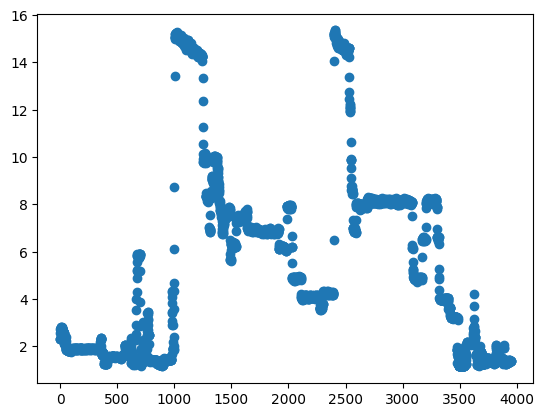

In [81]:
# E1 FFlow
flight_id = 6866
flight_mask = hierarchy_df.index == flight_id
y = "E1 FFlow"
plt.scatter(hierarchy_df.loc[flight_mask, "timestep"], hierarchy_df.loc[flight_mask, y])

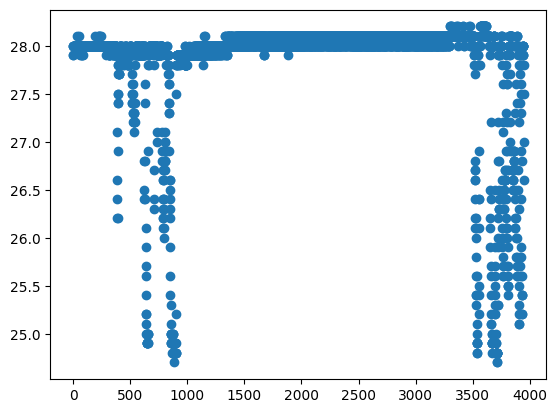

In [ ]:
# volt1
plt.scatter(hierarchy_df.loc[flight_mask, "timestep"], hierarchy_df.loc[flight_mask, "volt1"])